### Problem Description

The Poisson process is one of the most widely-used counting processes. It is usually used in scenarios where we are counting the occurrences of certain events that appear to happen at a certain rate, but completely at random (without a certain structure). In mathematics, Poisson process is described by Poisson distribution has the following form

$$
p(n|\lambda) = \frac{1}{n!} \lambda^n e^{-\lambda}
$$

where λ > 0 is the rate of the Poisson process, and n is the number of observations per unit of time, n = {1, 2, . . .}. To derive the posterior distribution, we must deﬁne a prior. A natural choice is the gamma distribution distribution, which is a conjugate prior for the Poisson distribution

$$
\dfrac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}
$$

where α is the shape parameter and β is the inverse scale parameter. A special case of the gamma is the exponential, Gamma(α = 1, β)

$$
\beta e^{-\beta \lambda}
$$

### Belief Network

<img src="img/poisson.png" width="300">

### Create Model in PyMC3

As what we did in wet grass example, model definition is a process of claiming variables with proper distributions. Here, we'll use *HalfNormal*, which is a normal distribution for positive numbers; *Gamma*, corresponds to Gamma function; and *Poisson* distribution.

There are two things you should notice here:

First, we use observed random variable here (N, corresponds to data). Normally, you can pass a concrete array to keyword *observed*. However, if you want to apply another data to the model, this method won't work. Instead, you can create a dynamic space to contain your data wich function *theano.shared* and modify the value of it later.

Second, if you noticed, we add a small number in definition of variable $r$. This is because *Gamma* distribution require $\alpha$ and $\beta$ both be positive.

In [10]:
import numpy, pymc3, theano

nobserve = 1000
# standard variance for priors
alphasd = 2
betasd  = 2
# create shared memory for changing observations
obsdata = theano.shared(numpy.zeros(nobserve))
# get a tiny number to avoid 0, even it is highly unlikely
eps = numpy.finfo(numpy.double).tiny

with pymc3.Model() as model:
    alpha = pymc3.HalfNormal('alpha', sd=alphasd)
    beta  = pymc3.HalfNormal('beta', sd=betasd)
    # varibles depends on other variables
    r = pymc3.Gamma('r', alpha=alpha+eps, beta=beta+eps)
    n = pymc3.Poisson('n', mu=r, observed=obsdata)

### Generate Data

For a meaningful experiment, we need to generate data following our assumption. Here, we create random parameters and then use it to sample data from *Poisson* distribution. Idealy, maximum posterior estimation should recover our random parameters here.

In [11]:
# initialize ground truth with random values
gtruthA = numpy.absolute(numpy.random.normal(scale=alphasd)) + eps
gtruthB = numpy.absolute(numpy.random.normal(scale=betasd)) + eps
gtruthR = numpy.random.gamma(gtruthA, 1 / gtruthB)
# print ground truth in output
print('Ground Truth of Alpha : ', gtruthA)
print('Ground Truth of Beta  : ', gtruthB)
print('Ground Truth of Rate  : ', gtruthR)
# generate data sample with generated parameters
with pymc3.Model() as dataModel:
    d = pymc3.Poisson('d', mu=gtruthR)
    # get data by sampling
    trace = pymc3.sample(nobserve, chains=1)
    # set observation data
    obsdata.set_value(trace[d])

Ground Truth of Alpha :  5.17090886598
Ground Truth of Beta  :  0.0510551771445
Ground Truth of Rate  :  91.36956626262433


Sequential sampling (1 chains in 1 job)
Metropolis: [d]
100%|██████████| 1500/1500 [00:00<00:00, 7275.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Posterior Estimation through Sampling

Here, we utilize sampling process to generate samples following defined model with given data. And then use plot to illustrate posterior of each variable.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_log__, beta_log__, alpha_log__]
100%|██████████| 30500/30500 [00:44<00:00, 685.10it/s]
The acceptance probability does not match the target. It is 0.887798920612, but should be close to 0.8. Try to increase the number of tuning steps.


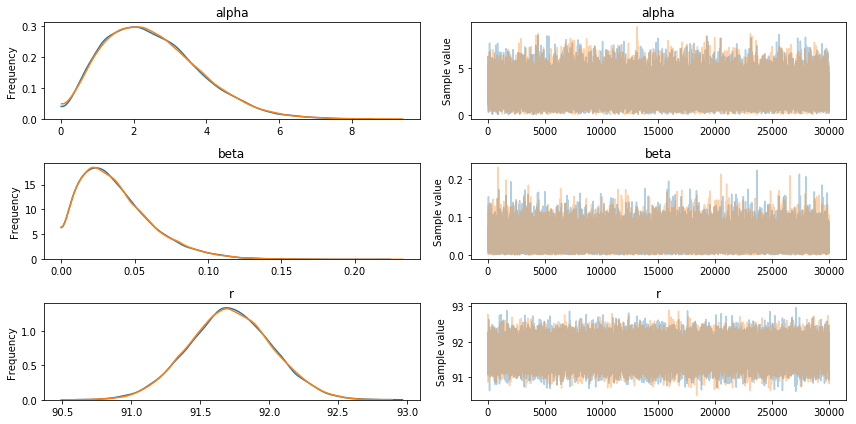

In [12]:
%matplotlib inline

nsamples = 30000
# sampling the model with given data
with model:
    # get sample from model with given observed data
    trace = pymc3.sample(nsamples)
    # illustrate samples
    pymc3.traceplot(trace)

If your run this process multiple times, you'll find estimation of $r$ is significantly bettern than $\alpha$ and $\beta$, why?